In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.9,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

#tf.compat.v1.disable_eager_execution()

우리는 컨브넷이 무엇인지 그리고 CV문제에 어떻게 잘 맞는지 배웠습니다.
* 입력의 부분 패치에서 특성을 뽑아내어 구조적인 표현을 만들고 데이터를 효율적으로 사용하는 합성곱 연산의 능력때문입니다.
* 시퀀스 처리에도 연관있습니다. 시간을 2D 이미지의 높이와 너비 같은 공간의 다룰 수 있습니다

1D ConvNet은 특정 시퀀스 처리 문제에서 RNN과 견줄 만합니다. 일반적으로 계상 비용이 저렴합니다. 1D 컨브넷은 전형적으로 **팽창된 커널 (dilated kernel)**과 함께 사용됩니다.

### 시퀀스 데이터를 위한 1D 합성곱 이해하기

2D 합성곱에서는 이미지 텐서에서 2D 패치를 추출하고 모든 패치에 동일한 변환을 적용합니다. 같은 방식으로 시퀀스에서 1D 패치 (부분 시퀀스)를 추출하여 1D 합성곱을 적용합니다.

<br></br>
![](../images/6-4-convnet.png)
<br></br>

이런 1D 합성곱 층은 시퀀스에 있는 지역 패턴을 인식할 수 있습니다. 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있습니다. 이는 1D 컨브넷에 **시간의 이동에 대한 이동 불변성 (translation invariant)**을 제공합니다. 예를 들어 크기 5인 윈도우를 사용하여 문자 시퀀스를 처리하는 1D ConvNet은 5개 이하의 단어나 단어의 부분을 학습합니다. 이 컨브넷은 이 단어가 입력 시퀀스의 어느 문장에 있더라도 인식할 수 있습니다. 따라서 문자 수준의 1D 컨브넷은 단어 형태학에 관해 학습할 수 있습니다.

### 시퀀스 데이터를 위한 1D Pooling

1D Pooling 연산은 2D Pooling 연산과 동일합니다. 입력에서 1D 패치를 추출하고 **최댓값**을 출력하거나 **평균값**을 출력합니다. 2D 컨브넷과 마찬가지로 1D 입력의 길이를 줄이기 위해 사용합니다. (서브샘플링 **subsampling**)

### 1D ConvNet 구현

* (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다.
* 합성곱 윈도우는 시간 축의 1D 윈도우입니다. (입력 텐서의 두번째 축)

##### IMDB 데이터 전처리하기

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print("데이터 로드...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)
print(len(x_train), "훈련 시퀀스")
print(len(x_test), "테스트 시퀀스")

print("시퀀스 패딩 (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen = max_len)
x_test = sequence.pad_sequences(x_test, maxlen = max_len)
print("x_train 크기:", x_train.shape)
print("x_test 크기:", x_test.shape)

데이터 로드...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


Conv1D와 MaxPooling1D 층을 쌓고 **전역 풀링 층 (GlobalAveragePooling1D 또는 GlobalMaxPooling1D)**이나 **Flatten 층**으로 마칩니다.
* GlobalAveragePooling1D 또는 GlobalMaxPooling1D 층은 *(samples, timesteps, features)* 크기의 텐서를 입력받고 *(samples, features)* 크기의 텐서를 출력받습니다.
* 즉 시간 축 전체에 풀링을 적용합니다
* 이 구조는 3D 입력을 2D 출력으로 바꾸므로 분류나 회귀를 위해 하나 이상의 Dense 층을 추가할 수 있습니다

##### IMDB 데이터에 1D 컨브넷을 훈련하고 평가하기

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length = max_len))
model.add(layers.Conv1D(32, 7, activation = "relu"))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation = "relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(lr = 1e-4),
              loss = "binary_crossentropy",
              metrics = ['acc'])

history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

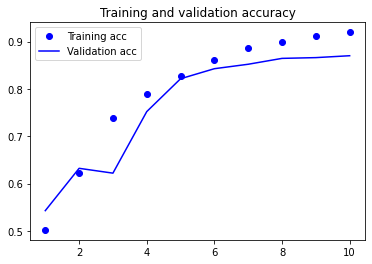

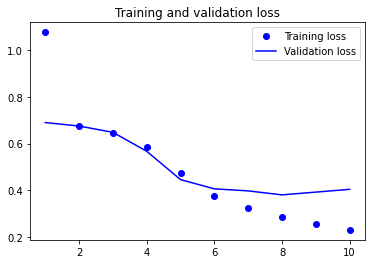

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도는 LSTM보다 낮지만 더 빠르게 계산됩니다.

### CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

1D ConvNet이 입력 패치를 **독립적**으로 처리하기 때문에 RNN과 달리 타임스텝의 순서에 민감하지 않습니다.
* 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있습니다
* 상위 층은 원본 입력에서 긴 범위를 보게 될 것입니다
* 이런 방법은 순서를 감지하기 부족합니다

온도 예측 문제에서는 1D 컨브넷을 적용해서 이를 확인해보겠습니다. 이 문제는 순서를 감지해야 좋은 예츨을 만들어 낼 수 있습니다

##### 온도 데이터에 1D ConvNet을 훈련하고 평가하기

In [5]:
import os
import numpy as np

data_dir = "./data/jena_climate/"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values
    
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen =  generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      #shuffle = True,
                      step = step,
                      batch_size = batch_size)

test_gen =  generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      #shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = "relu", input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = "relu"))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = "relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 7s 13ms/step - loss: 0.4475 - val_loss: 0.4273
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3662 - val_loss: 0.4730
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3394 - val_loss: 0.4310
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3243 - val_loss: 0.4468
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3132 - val_loss: 0.4712
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3021 - val_loss: 0.4459
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2948 - val_loss: 0.4350
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2829 - val_loss: 0.4509
Epoch 9/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2814 - val_loss: 0.4509
Epoch 10/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2727 - val_lo

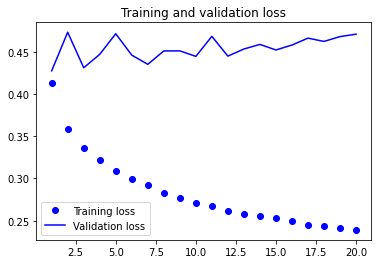

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 MAE는 0.40대에 머물렀습니다. 작은 컨브넷을 사용해서 상식 수준의 기준점을 넘지 못했습니다.
* 이는 컨브넷이 입력 시계열에 있는 패턴을 보고 이 패턴의 시간 축의 위치 - 시작인지 끝인지 등 - 을 고려하지 않았기 때문
* 최근 데이터 포인트일수록 오래된 데이터 포인트와는 다르게 해석해야 하기 때문에 컨브넷이 의미 있는 결과를 만들지 못합니다. 

이런 컨브넷의 한계는 IMDB 데이터에서는 문제가 되지 않습니다.
* 긍정 또는 부정적인 감성과 연관된 패턴의 중요성은 입력 시퀀스에 나타난 위치와 무관하기 때문

컨브넷의 *속도와 경량함*을 RNN의 *순서 감지 능력*과 결합하는 한가지 전략은:
* 1D 컨브넷을 RNN 이전에 *전처리 단계*로 사용하는 것입니다.
* 수천개의 스텝을 가진 시퀀스같이 RNN으로 처리하기에는 현실적으로 너무 긴 시퀀스를 다룰때 도움됩니다
* 컨브넷이 긴 입력 시퀀스를 더 짧은 고수준 특성의 시퀀스로 변환합니다

<br></br>
![](../images/6-4-convnetrnn.png)
<br></br>

##### 고밀도 데이터 제너레이터로 예나 데이터넷 준비

In [8]:
## 30분마다 1포인트
step = 3
lookback = 1440
delay = 144

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step)

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step) 

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      step = step) 

val_steps = (300000 - 200001 - lookback) // 128

test_steps = (len(float_data) - 300001 - lookback) // 128

이 모델은 2개의 Conv1D 층 다음에 GRU층을 놓았습니다

##### 1D ConvNet과 GRU층을 연결한 모델

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = "relu",
                        input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = "relu"))
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 92s 181ms/step - loss: 0.3184 - val_loss: 0.7245
Epoch 2/20
500/500 [==============================] - 88s 176ms/step - loss: 0.3086 - val_loss: 0.8669
Epoch 3/20
500/500 [==============================] - 87s 174ms/step - loss: 0.2911 - val_loss: 0.7859
Epoch 4/20
500/500 [==============================] - 87s 174ms/step - loss: 0.2841 - val_loss: 0.9378
Epoch 5/20
500/500 [==============================] - 87s 173ms/step - loss: 0.3086 - val_loss: 0.9137
Epoch 6/20
500/500 [==============================] - 87s 174ms/step - loss: 0.2842 - val_loss: 0.8846
Epoch 7/20
500/500 [==============================] - 92s 185ms/step - loss: 0.3292 - val_loss: 1.1639
Epoch 8/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2912 - val_loss: 1.0588
Epoch 9/20
500/500 [==============================] - 91s 183ms/step - loss: 0.3212 - val_loss: 1.1584
Epoch 10/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2792

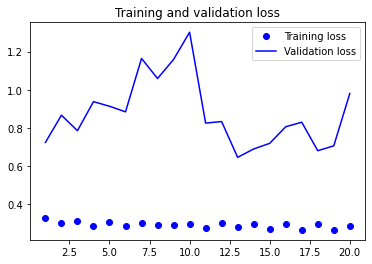

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()